In this tutorial, we will introduce the data interface of a SPIDER-regulated planner, 

including the input and output data type as well as how to convert common data into those. 

It is based on spider-python==0.1.16.4 

If you are using a different version, the code may not work as expected. 


In [1]:
import numpy as np

import spider
import spider.elements as elm
import spider.visualize as vis


Cython module not found. Use pyximport temporally


# 1. Input

In spider, the input data of a planner is represented as a triple $(E, P, M)$,
 
where $E$ is the information of the ego vehicle's state (class VehicleState) from the localization module,

and $P$ is the perception results from the perception module, which could be tracking boxes (class TrackingBoxList) or raster representation (class OccupancyGrid2D).

and $M$ is the local map information along with routing information from the mapping & routing module, which contains the vectorized lanes and the routing path / road options (class RoutedLocalMap).

For fast construction of the input data, we provide the corresponding class method to instantiate from common data types.

In [2]:
# Assume that we have an environment defined with the following data

# ego vehicle
ego_len, ego_wid = 5.0, 2.0
ego_x, ego_y, ego_yaw = 0., 0., 0.
ego_vx, ego_vy = 5.0, 0.0
ego_ax, ego_ay = 5.0, 0.0

# surrounding objects
x0, y0, len0, wid0, yaw0, vx0, vy0 = 15., -2., 1.0, 1.0, 90.0*np.pi/180, 0., 1.0
x1, y1, len1, wid1, yaw1, vx1, vy1 = 30., 3.5, 5.0, 2.0, np.pi, -5.0, 0.0

# available lanes
centerline0 = np.array([[0., 0.], [10., 0.], [20., 0.], [30., 0.], [40., 0.]])
centerline1 = np.array([[0., 3.5], [10., 3.5], [20., 3.5], [30., 3.5], [40., 3.5]])
lane_width = 3.5
speed_limit = 60/3.6


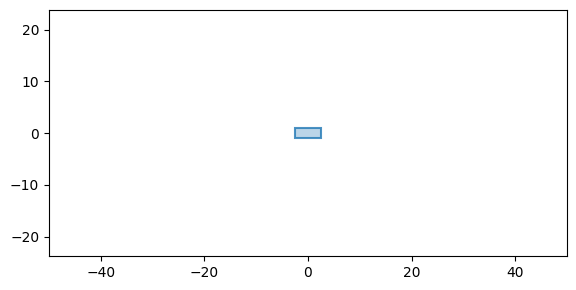

In [3]:

####### build the ego vehicle state #######

# METHOD 1: default instantiation of vehicle state
ego_state = elm.VehicleState(
    elm.Transform(
        elm.Location(ego_x, ego_y, 0.0),
        elm.Rotation(0.0, 0.0, ego_yaw)
    ), # transform
    elm.Vector3D(ego_vx, ego_vy, 0.0), # velocity
    elm.Vector3D(ego_ax, ego_ay, 0.0), # acceleration
    ego_len, ego_wid # ego vehicle size
)
# METHOD 2: or you can simply construct it with
ego_state = elm.VehicleState.from_kine_states(
    ego_x, ego_y, ego_yaw, 
    ego_vx, ego_vy, ego_ax, ego_ay, 
    ego_len, ego_wid
)
# METHOD 3: or you can construct it from a given step from a trajectory
# to be continued


# initialize the visualization figure
vis.figure(figsize=(6,3))
vis.ego_centric_view(ego_x, ego_y)
vis.draw_ego_vehicle(ego_state)
# vis.draw_ego_vehicle(ego_state, color='C0', fill=True, alpha=0.3, linestyle='-', linewidth=1.5)


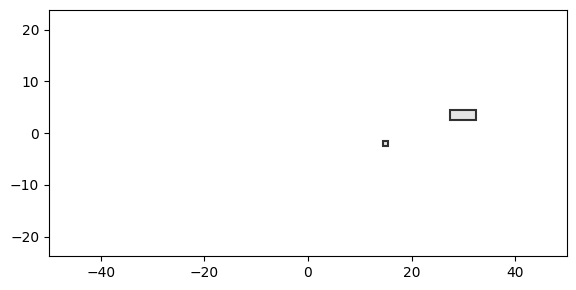

In [4]:
####### build the perception results #######

# METHOD 1: default instantiation of tracking box list
tbox_list = elm.TrackingBoxList([
    elm.TrackingBox([x0, y0, len0, wid0, yaw0], vx0, vy0, id=0, class_label=0), # TrackingBox(obb, vx, vy, id, class_label)
    elm.TrackingBox([x1, y1, len1, wid1, yaw1], vx1, vy1, id=1, class_label=1)
])
# P.S.: obb means oriented bounding box, which is represented as [x, y, length, width, yaw]

# METHOD 2: or you can construct it from kinematics features
obbs_with_velocity = [
    [x0, y0, len0, wid0, yaw0, vx0, vy0],
    [x1, y1, len1, wid1, yaw1, vx1, vy1]
]
tbox_list = elm.TrackingBoxList.from_obbs(obbs_with_velocity)

# initialize the visualization figure
vis.figure(figsize=(6,3))
vis.ego_centric_view(ego_x, ego_y)
vis.draw_trackingbox_list(tbox_list)


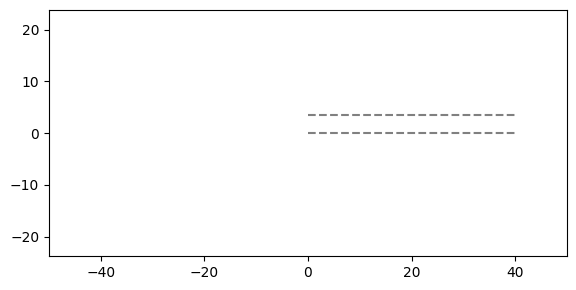

In [5]:
####### build the local map #######

# METHOD 1: default instantiation of local map
local_map = elm.RoutedLocalMap(
    lanes=[ # Lane(id, centerline, width, speed_limit, resample, resample_resolution)
        elm.Lane(0, centerline0, lane_width, speed_limit, resample=True), 
        elm.Lane(1, centerline1, lane_width, speed_limit, resample=True)
    ]
)

# METHOD 2: or you can construct it from given lane centerlines
local_map = elm.RoutedLocalMap.from_centerlines([centerline0, centerline1], lane_width, speed_limit, resample=True)

vis.figure(figsize=(6,3))
vis.ego_centric_view(ego_x, ego_y)
vis.draw_local_map(local_map)

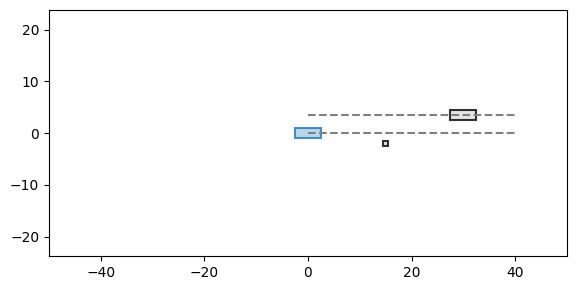

In [6]:
vis.figure(figsize=(6,3))
vis.ego_centric_view(ego_x, ego_y)
vis.draw_ego_vehicle(ego_state)
vis.draw_trackingbox_list(tbox_list)
vis.draw_local_map(local_map)

# 2. Design and configure a planner and get access to it

In [7]:
from spider.planner_zoo import LatticePlanner

print(LatticePlanner.default_config()) # the default parameters of a planner

{'output': 0, 'steps': 20, 'dt': 0.2, 'ego_veh_length': 5.0, 'ego_veh_width': 2.0, 'max_speed': 18.055555555555554, 'min_speed': 0, 'max_acceleration': 10, 'max_deceleration': 10, 'max_curvature': 100, 'safe_distance': (1.0, 0.2), 'end_s_candidates': (10, 20, 40, 60), 'end_l_candidates': (-3.5, 0, 3.5), 'end_v_candidates': (0.0, 5.555555555555556, 11.111111111111112, 16.666666666666668), 'end_T_candidates': (1, 2, 4, 8), 'print_info': True, 'constraint_flags': {1, 2, 3, 4, 6}}


In [8]:

planner = LatticePlanner({
    "steps": 15,
    "dt": 0.2,
    'end_l_candidates': (-3.5,-0.8, 0, 0.8, 3.5)
}) # configure a planner

# PLANNING MAIN FUNCTION
traj = planner.plan(ego_state, tbox_list, local_map)

Optimal trajectory found! s_dot_end=16.67,l_end=-3.50
Planning Succeed! Time: 0.06 seconds, FPS: 17.77


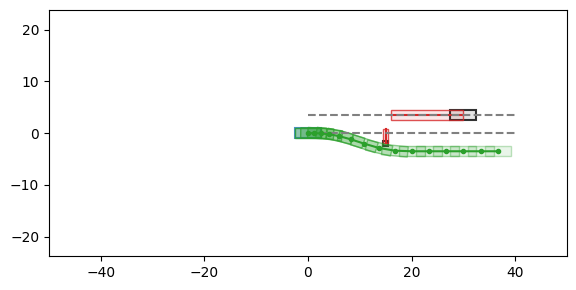

In [9]:
# draw the whole process
vis.figure(figsize=(6,3))
vis.ego_centric_view(ego_x, ego_y)
vis.draw_ego_vehicle(ego_state)
vis.draw_trackingbox_list(tbox_list)
vis.draw_local_map(local_map)
vis.draw_trajectory(traj, '.-', show_footprint=True, color='C2') 

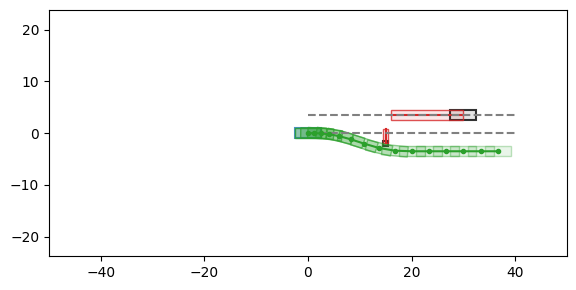

In [10]:
# a simpler way to visualize the result
vis.figure(figsize=(6,3))
vis.lazy_draw(ego_state, tbox_list, local_map, traj)

# 3. output

Trajectory class

In [11]:
dir(traj)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_list',
 '_sequential_properties',
 'a',
 'appendStateFromModel',
 'centripetal_acceleration',
 'clearFrenetState',
 'clearState',
 'concat',
 'convert_to_acc_steer',
 'csp',
 'curvature',
 'debug_info',
 'densify',
 'derivative',
 'dt',
 'from_sl_array',
 'from_trajectory_array',
 'heading',
 'jerk',
 'l',
 'l_2dot',
 'l_2prime',
 'l_3dot',
 'l_3prime',
 'l_dot',
 'l_prime',
 'offsetAdjust',
 'offset_center',
 's',
 's_2dot',
 's_3dot',
 's_dot',
 'steer',
 'steer_velocity',
 'step',
 'steps',
 't',
 'to_dict',
 'trajectory_array',
 'trajectory_sl_array',
 'truncate',
 'v',
 'x',
 'y']

In [12]:
traj.x, traj.y

([0.0,
  1.1093333333333335,
  2.469333333333333,
  4.1160000000000005,
  6.069333333333335,
  8.333333333333334,
  10.896,
  13.729333333333336,
  16.789333333333335,
  20.016000000000002,
  23.333333333333332,
  26.666666666666668,
  30.000000000000007,
  33.333333333333336,
  36.66666666666667],
 [0.0,
  -0.005486714996109471,
  -0.05427704312781604,
  -0.2186497288476726,
  -0.5869380146567185,
  -1.2131679205246915,
  -2.042430270379556,
  -2.864961757767458,
  -3.387830111640543,
  -3.5,
  -3.500000000000012,
  -3.5000000000000235,
  -3.5000000000000355,
  -3.5000000000000475,
  -3.500000000000059])

In [13]:
traj.trajectory_array

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.10933333e+00, -5.48671500e-03],
       [ 2.46933333e+00, -5.42770431e-02],
       [ 4.11600000e+00, -2.18649729e-01],
       [ 6.06933333e+00, -5.86938015e-01],
       [ 8.33333333e+00, -1.21316792e+00],
       [ 1.08960000e+01, -2.04243027e+00],
       [ 1.37293333e+01, -2.86496176e+00],
       [ 1.67893333e+01, -3.38783011e+00],
       [ 2.00160000e+01, -3.50000000e+00],
       [ 2.33333333e+01, -3.50000000e+00],
       [ 2.66666667e+01, -3.50000000e+00],
       [ 3.00000000e+01, -3.50000000e+00],
       [ 3.33333333e+01, -3.50000000e+00],
       [ 3.66666667e+01, -3.50000000e+00]])

In [13]:
# %matplotlib

# vis.figure(figsize=(6,3))

# for i in range(10):
    

# vis.ego_centric_view(ego_x, ego_y)